In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [3]:
#Read CSV
stores = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/stores.csv')
features = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/features.csv/features.csv', skipinitialspace= True)
walmart = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/train.csv/train.csv', skipinitialspace= True)
test = pd.read_csv('/content/drive/MyDrive/DS 502 Project/walmart-recruiting-store-sales-forecasting/test.csv/test.csv', skipinitialspace= True)

In [4]:
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
#Merge Data 
merged_df = walmart.merge(stores, how='left').merge(features,how = 'left')
#merged_test = test.merge(stores, how='left').merge(features,how = 'left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [8]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [9]:
# #Time transformation 
def time_trans(df):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['WeekOfYear'] = pd.to_datetime(df['Date']).dt.isocalendar().week
    return df

time_trans(merged_df)
#time_trans(merged_test)

merged_df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,9


**EDA**

In [10]:
weekly_sales = merged_df.groupby(['Year','WeekOfYear'], as_index = False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2010 = merged_df.loc[merged_df['Year']==2010].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2011 = merged_df.loc[merged_df['Year']==2011].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2012 = merged_df.loc[merged_df['Year']==2012].groupby(['WeekOfYear']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales_2010.info

<bound method DataFrame.info of             Weekly_Sales           
                    mean     median
WeekOfYear                         
5           16836.121997   7904.690
6           16352.056032   8365.095
7           16216.658979   8411.250
8           14899.549688   7235.800
9           15921.015727   7717.975
10          15546.850545   7529.550
11          15286.773578   7915.600
12          14975.894486   7345.130
13          17098.620298   8658.890
14          16050.589780   8006.270
15          15347.713003   7506.590
16          15252.114749   7644.980
17          14967.509147   7384.900
18          16542.716071   8467.060
19          15513.374470   8022.935
20          15499.865359   7847.140
21          16428.449453   8306.600
22          17246.922034   8596.010
23          16440.889213   8114.880
24          16281.041446   8127.630
25          15978.414909   8067.450
26          16769.792424   8117.290
27          16500.010117   7867.660
28          15940.675484   7828.

Text(0.5, 1.0, 'Average Weekly Sales per Year')

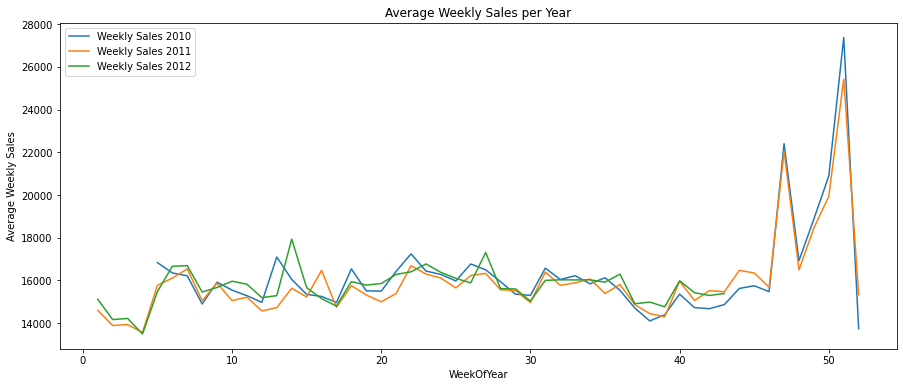

In [11]:
plt.figure(figsize= (15,6))
sns.lineplot(x = weekly_sales_2010['Weekly_Sales']['mean'].index, y = weekly_sales_2010['Weekly_Sales']['mean'], label = 'Weekly Sales 2010')
sns.lineplot(x = weekly_sales_2011['Weekly_Sales']['mean'].index, y = weekly_sales_2011['Weekly_Sales']['mean'], label = 'Weekly Sales 2011')
sns.lineplot(x = weekly_sales_2012['Weekly_Sales']['mean'].index, y = weekly_sales_2012['Weekly_Sales']['mean'], label = 'Weekly Sales 2012')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales per Year')

Text(0.5, 1.0, 'Store size by type')

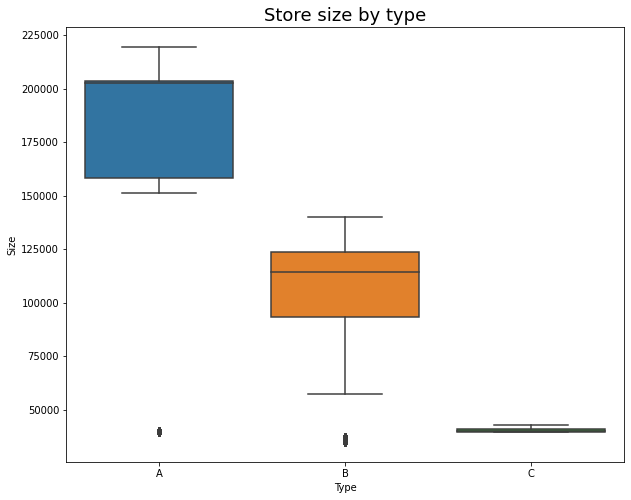

In [12]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'Type', y = 'Size', data = merged_df)
plt.title('Store size by type', fontsize=18)

Text(0.5, 1.0, 'Weekly Sales per Store type')

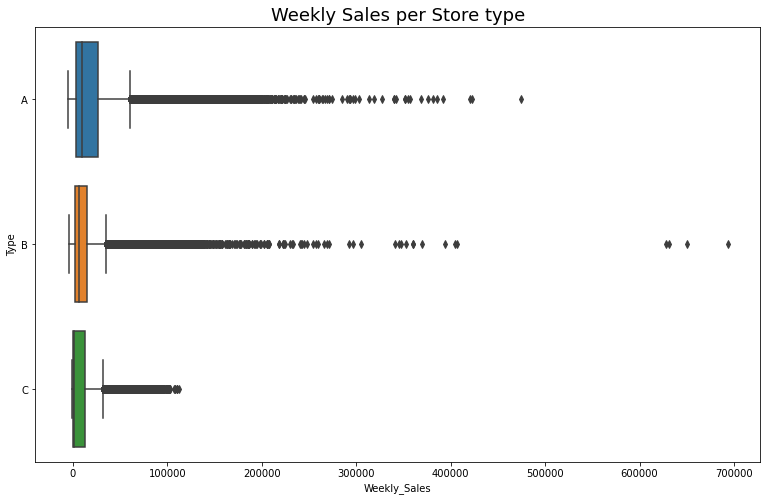

In [13]:
plt.figure(figsize = (13,8))
sns.boxplot(x = 'Weekly_Sales', y = 'Type', data = merged_df, orient = 'h')
plt.title('Weekly Sales per Store type', fontsize=18)

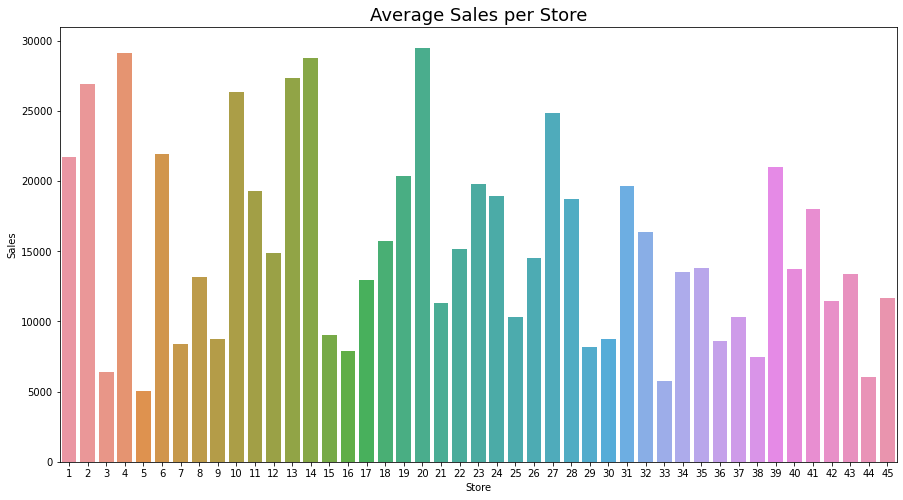

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(x='Store', y='Weekly_Sales',data= merged_df,ci=None)
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

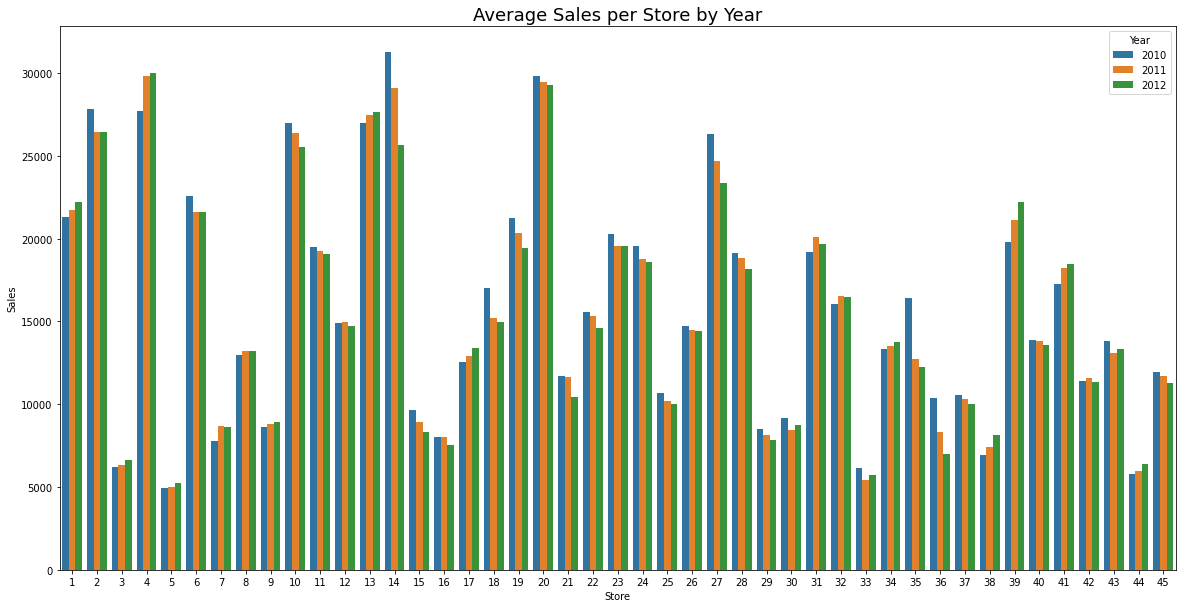

In [15]:
plt.figure(figsize=(20,10))
sns.barplot( x='Store', y='Weekly_Sales',data= merged_df, hue='Year',ci=None)
plt.title('Average Sales per Store by Year', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

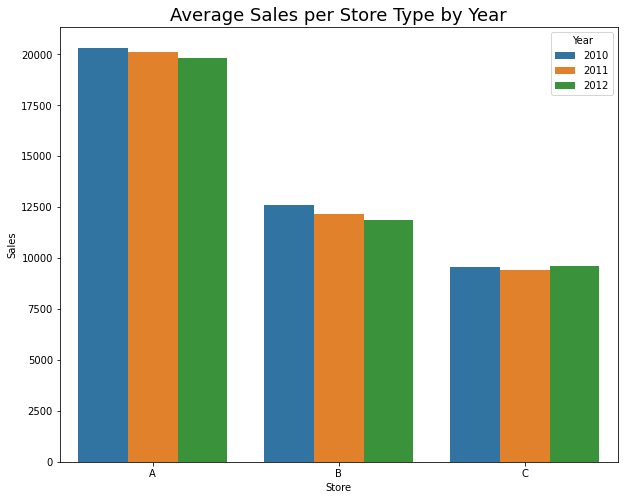

In [16]:
plt.figure(figsize=(10,8))
sns.barplot( x='Type', y='Weekly_Sales',data= merged_df, hue='Year', ci=None)
plt.title('Average Sales per Store Type by Year', fontsize=18)
plt.ylabel('Sales')
plt.xlabel('Store')
plt.show()

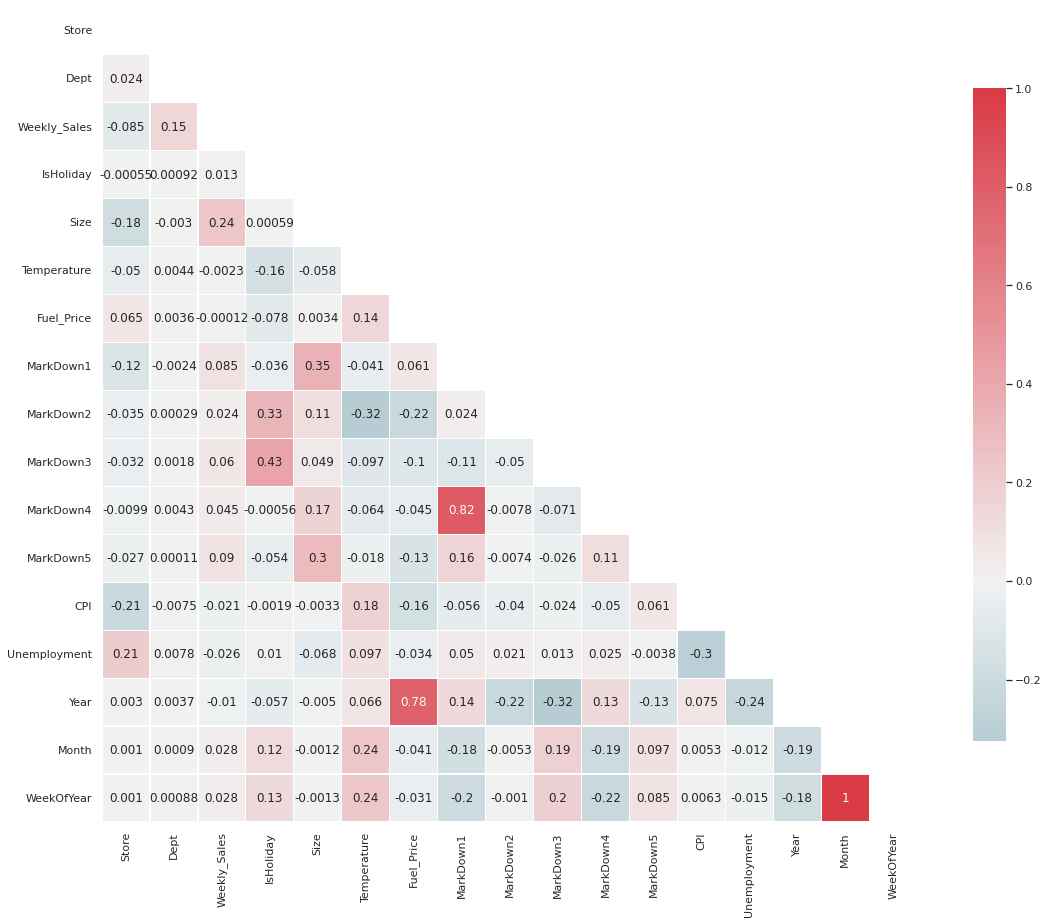

In [17]:
sns.set(style="white")

corr = merged_df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8}, annot=True)
plt.show()

In [18]:
#define X(independent),Y(dependent)
X = merged_df[['Store', 'Dept', 'Size', 'IsHoliday', 'Type',
       'Temperature', 'CPI', 'Unemployment', 'Year', 'Month','WeekOfYear']].copy()

y = merged_df['Weekly_Sales'].copy()

In [19]:
num = ['Size',
       'Temperature','CPI', 'Unemployment', 'Year', 'Month']
cat = ['Store', 'Dept', 'IsHoliday', 'Type']
X[num].isna().sum()

Size            0
Temperature     0
CPI             0
Unemployment    0
Year            0
Month           0
dtype: int64

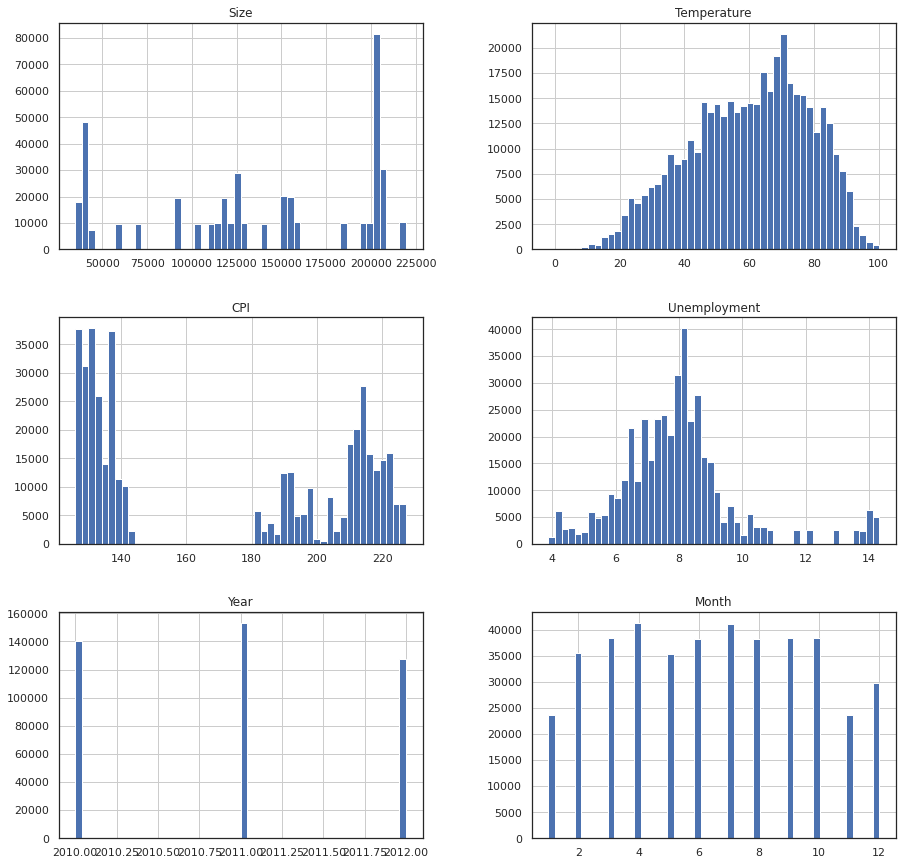

In [20]:
#Check Distribution

X[num].hist(bins=50, figsize=(15,15))

plt.show()

In [21]:
#Correlation w.r.t Weekly sales

df_corr = merged_df[merged_df.columns[:]].corr()['Weekly_Sales'][:]
df_corr = df_corr.drop("Weekly_Sales")
df_corr

Store          -0.085195
Dept            0.148032
IsHoliday       0.012774
Size            0.243828
Temperature    -0.002312
Fuel_Price     -0.000120
MarkDown1       0.085251
MarkDown2       0.024130
MarkDown3       0.060385
MarkDown4       0.045414
MarkDown5       0.090362
CPI            -0.020921
Unemployment   -0.025864
Year           -0.010111
Month           0.028409
WeekOfYear      0.027673
Name: Weekly_Sales, dtype: float64

In [22]:
X.head()

,Store,Dept,Size,IsHoliday,Type,Temperature,CPI,Unemployment,Year,Month,WeekOfYear
0,1,1,151315,False,A,42.31,211.096358,8.106,2010,2,5
1,1,1,151315,True,A,38.51,211.242170,8.106,2010,2,6
2,1,1,151315,False,A,39.93,211.289143,8.106,2010,2,7
3,1,1,151315,False,A,46.63,211.319643,8.106,2010,2,8
4,1,1,151315,False,A,46.50,211.350143,8.106,2010,3,9


In [23]:
X = pd.concat([X[num],X[cat]],axis=1)

In [24]:
X.head()

,Size,Temperature,CPI,Unemployment,Year,Month,Store,Dept,IsHoliday,Type
0,151315,42.31,211.096358,8.106,2010,2,1,1,False,A
1,151315,38.51,211.242170,8.106,2010,2,1,1,True,A
2,151315,39.93,211.289143,8.106,2010,2,1,1,False,A
3,151315,46.63,211.319643,8.106,2010,2,1,1,False,A
4,151315,46.50,211.350143,8.106,2010,3,1,1,False,A


In [25]:
X['IsHoliday'] = X['IsHoliday'].astype('str').map({'True':0,'False':1})
X.Type = X.Type.map({'A':2,'B':1,'C':0})

In [26]:
#Scaling (Normalization)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X[X.columns] = scaler.transform(X)

In [27]:
X.head()

,Size,Temperature,CPI,Unemployment,Year,Month,Store,Dept,IsHoliday,Type
0,0.630267,0.434149,0.840500,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
1,0.630267,0.396967,0.841941,0.405118,0.0,0.090909,0.0,0.0,0.0,1.0
2,0.630267,0.410861,0.842405,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
3,0.630267,0.476419,0.842707,0.405118,0.0,0.090909,0.0,0.0,1.0,1.0
4,0.630267,0.475147,0.843008,0.405118,0.0,0.181818,0.0,0.0,1.0,1.0


# (Bhavin and Wentao)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

In [29]:
def eval_metric(predict):
    scores = pd.DataFrame([mean_absolute_error(y_test, predict),
                           mean_squared_error(y_test, predict, squared = False),
                          r2_score(y_test, predict),
                          r2_score(y_test, predict, multioutput='variance_weighted')],columns=['score'],
                          
                          index=['MAE','RMSE','R2 score','Adjusted R2'])
    return scores

In [30]:
def model_eval(model, modelname):   
    modelname = model()
    modelname.fit(X_train, y_train)
    preds = modelname.predict(X_test)
    try:
        feat_imp = modelname.feature_importances_
        indices = np.sort(feat_imp)[:10]
        plt.figure(figsize = (10,6))
        plt.bar(X_train.columns, feat_imp)
        plt.title('Feature Importance plot')
    except:
        pass
    return eval_metric(preds), modelname, preds

[23:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


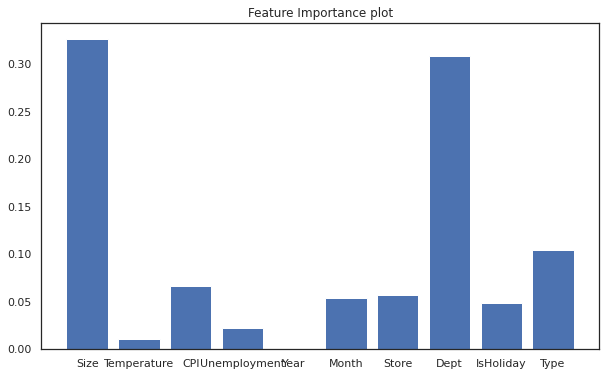

In [31]:
metrics, model, preds = model_eval(XGBRegressor,'xgb')

In [32]:
metrics

,score
MAE,6931.718933
RMSE,11577.411970
R2 score,0.738232
Adjusted R2,0.738232


In [33]:
print('Feature importance:')
print(pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15))

Feature importance:
Size            0.327093
Dept            0.309009
Type            0.104282
CPI             0.066248
Store           0.056831
Month           0.054174
IsHoliday       0.048870
Unemployment    0.022916
Temperature     0.010576
Year            0.000000
dtype: float32


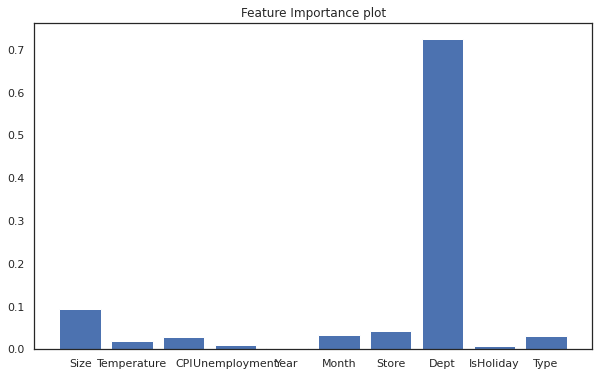

In [34]:
metrics, model, preds = model_eval(ExtraTreesRegressor,'ext')

In [35]:
metrics

,score
MAE,1729.521437
RMSE,4571.721481
R2 score,0.959182
Adjusted R2,0.959182


In [36]:
print('Feature importance:')
print(pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15))

Feature importance:
Dept            0.726070
Size            0.094321
Store           0.042015
Month           0.033431
Type            0.031906
CPI             0.028094
Temperature     0.020443
Unemployment    0.010859
IsHoliday       0.008711
Year            0.004149
dtype: float64


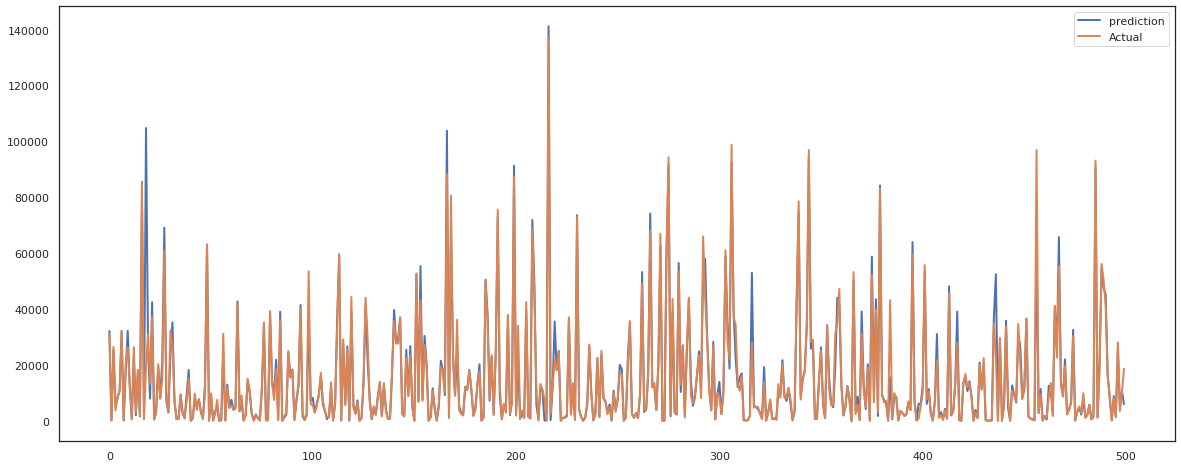

In [37]:
plt.figure(figsize=(20,8))
plt.plot(preds[25000:25500], label="prediction", linewidth=2.0)
plt.plot(y_test[25000:25500].values, label="Actual", linewidth=2.0)
plt.legend(loc="best")

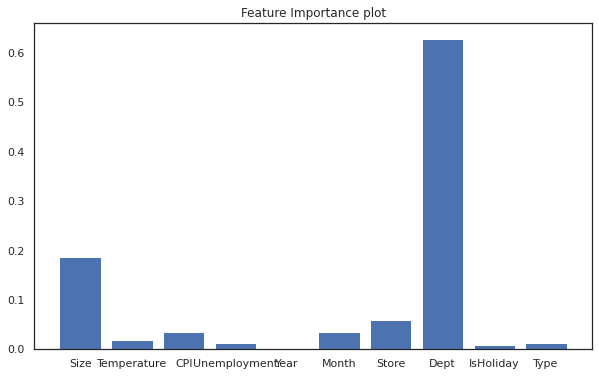

In [38]:
#Random Forest
metrics, model, preds = model_eval(RandomForestRegressor,'rf')

In [39]:
metrics

,score
MAE,1649.532393
RMSE,4333.515232
R2 score,0.963325
Adjusted R2,0.963325


In [40]:
print('Feature importance:')
print(pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15))

Feature importance:
Dept            0.628658
Size            0.185809
Store           0.058347
Month           0.035718
CPI             0.034714
Temperature     0.019106
Type            0.013716
Unemployment    0.012811
IsHoliday       0.009486
Year            0.001635
dtype: float64


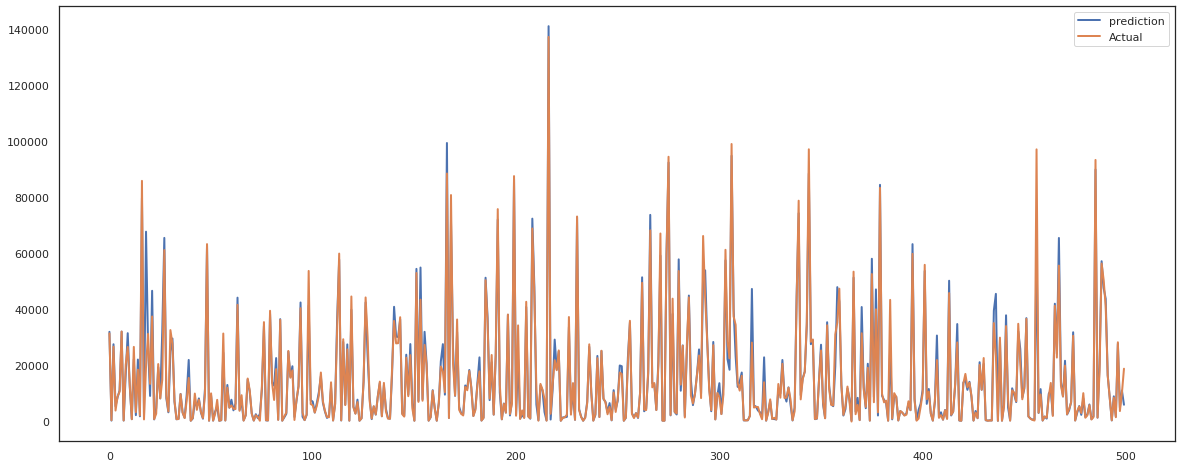

In [41]:
plt.figure(figsize=(20,8))
plt.plot(preds[25000:25500], label="prediction", linewidth=2.0, )
plt.plot(y_test[25000:25500].values, label="Actual", linewidth=2.0)
plt.legend(loc="best")

# Ridge and Elastic Net Regression Models (Mohamed)


In [42]:
#Categorical Columns one hot encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown = "ignore").fit(X[cat])
encoded_col = encoder.get_feature_names(cat)
X[encoded_col] = encoder.transform(X[cat]).toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
# Ridge Model Progressive Evaluation

tscv = TimeSeriesSplit()

TimeSeriesSplit(max_train_size=None, n_splits=5)

MSE_ridge = []
MAE_ridge = []
R2_ridge = []

n = 300
lambdas = np.linspace(0.00001, 1, 20)

ridge_cv = RidgeCV(alphas = lambdas, scoring = 'neg_mean_squared_error', normalize = True, cv= 5)
ridge_cv.fit(X, y)


for train_index, test_index in tscv.split(X):

  print('TRAIN:', train_index, 'TEST:', test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  ridge_model = Ridge(alpha = ridge_cv.alpha_, normalize= True)
  ridge_model.fit(X_train, y_train)
  pred = ridge_model.predict(X_test)
  
  MSE_ridge.append(mean_squared_error(y_test, pred))
  MAE_ridge.append(mean_absolute_error(y_test, pred))
  R2_ridge.append(r2_score(y_test, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipel

TRAIN: [    0     1     2 ... 70262 70263 70264] TEST: [ 70265  70266  70267 ... 140523 140524 140525]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


TRAIN: [     0      1      2 ... 140523 140524 140525] TEST: [140526 140527 140528 ... 210784 210785 210786]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


TRAIN: [     0      1      2 ... 210784 210785 210786] TEST: [210787 210788 210789 ... 281045 281046 281047]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


TRAIN: [     0      1      2 ... 281045 281046 281047] TEST: [281048 281049 281050 ... 351306 351307 351308]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


TRAIN: [     0      1      2 ... 351306 351307 351308] TEST: [351309 351310 351311 ... 421567 421568 421569]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [44]:
print('Metrics for Ridge Regression Model:')
print('Mean Root Square Error is :', np.mean(MSE_ridge)**0.5)
print('Mean Absolute Error is :', np.mean(MAE_ridge))
print('Mean R2 is :', np.mean(R2_ridge))

Metrics for Ridge Regression Model:
Mean Root Square Error is : 14488.815296131932
Mean Absolute Error is : 9102.31179769703
Mean R2 is : 0.5631775928804709


In [45]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

# Elastic Net Regression

tscv = TimeSeriesSplit()

TimeSeriesSplit(max_train_size=None, n_splits=5)

EN_cv = ElasticNetCV(alphas = lambdas, normalize = True, cv= 5)
EN_cv.fit(X, y)


MSE_EN = []
MAE_EN = []
R2_EN = []

for train_index, test_index in tscv.split(X):
  print('TRAIN:', train_index, 'TEST:', test_index)
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  en_model = ElasticNet(alpha = EN_cv.alpha_, normalize= True)
  en_model.fit(X_train, y_train)
  pred = en_model.predict(X_test)
  
  MSE_EN.append(mean_squared_error(y_test, pred))
  MAE_EN.append(mean_absolute_error(y_test, pred))
  R2_EN.append(r2_score(y_test, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


TRAIN: [    0     1     2 ... 70262 70263 70264] TEST: [ 70265  70266  70267 ... 140523 140524 140525]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


TRAIN: [     0      1      2 ... 140523 140524 140525] TEST: [140526 140527 140528 ... 210784 210785 210786]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


TRAIN: [     0      1      2 ... 210784 210785 210786] TEST: [210787 210788 210789 ... 281045 281046 281047]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


TRAIN: [     0      1      2 ... 281045 281046 281047] TEST: [281048 281049 281050 ... 351306 351307 351308]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


TRAIN: [     0      1      2 ... 351306 351307 351308] TEST: [351309 351310 351311 ... 421567 421568 421569]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  FutureWarning,


In [46]:
print('Metrics for ElasticNet Model:')
print('Mean Root Square Error is :', np.mean(MSE_EN)**0.5)
print('Mean Absolute Error is :', np.mean(MAE_EN))
print('Mean R2 is :', np.mean(R2_EN))

Metrics for ElasticNet Model:
Mean Root Square Error is : 15731.368391914613
Mean Absolute Error is : 10115.735230775541
Mean R2 is : 0.4764732339480032


# Lasso Regression (Jorge)

In [47]:
##LASSO obtain best alpha for the model through CV
lassocv=LassoCV(eps=1e-3,cv=5,random_state=1,max_iter=200)
lassocv.fit(X,y)
bestalpha=lassocv.alphas_[np.argmin(lassocv.mse_path_.mean(-1))]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21045668471.234375, tolerance: 16702127738.058662
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20044559797.625, tolerance: 16702127738.058662
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21958287378.992188, tolerance: 16702127738.058662
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228699809

In [48]:
#use best alpha to obtain the models performance
lassomod = Lasso(random_state=3,alpha=bestalpha)
tsf = TimeSeriesSplit(n_splits=5)
mse = []
mae =[]
r2 = []
adj_r2 = []
mods = []
for train_index, test_index in tsf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lassomod.fit(x_train, y_train)
    y_pred = lassomod.predict(x_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    mods.append(lassomod)
print('Metrics for Lasso Model:')
print('Mean Root Square Error is :', np.mean(mse)**0.5)
print('Mean Absolute Error is :', np.mean(mae))
print('Mean R2 is :', np.mean(r2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e+11, tolerance: 9.801e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e+11, tolerance: 1.315e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Metrics for Lasso Model:
Mean Root Square Error is : 14046.866959924846
Mean Absolute Error is : 8960.756546827219
Mean R2 is : 0.5890522191141174
